# Ch. 7. Benchmarking

## I. Why Benchmark?
By now, you (hopefully) understand a lot more about HPC, parallelism, concurrency, and distributed computing than you did before you started this course. You should feel fairly comfortable modifying serial code to make it parallel or concurrent, where appropriate, and you should feel fairly comfortable writing parallel algorithms and workflows yourself. In order to do this well, you need to be able to benchmark your algorithms and the systems they run on. You know the basics of how to analyze parallel algorithms, but it's always useful to collect empirical measurements, and it's also usually easier to collect empirical data than it is to do mathematical analysis of parallel algorithms.

So, now that we're through with that, what is benchmarking? A _benchmark_ is the act of running a computer program, a set of programs, or other operations, in order to assess the relative performance of an object, normally by running a number of standard tests and trials against it. Benchmarking is usually associated with assessing performance characteristics of computer hardware, for example, the floating point operation performance of a CPU, but there are circumstances when the technique is also applicable to software. In this notebook, we will be doing a bit of both. The following graph is an example of historical benchmarks going back to 1996:
![benchmarks of old](http://preshing.com/images/float-point-perf.png)

### Example 7.1 - Reading Files Vs Reading From Memory
Remember in Ch. 3 when I mentioned that you should try and stay away from reading and writing to disk as much as possible? I mentioned that it is much slower to read and write to disk than it is to memory. In this example, we're going to quantify that. I've designed a [python decorator](https://www.python.org/dev/peps/pep-0318/) to be used as a timer. In order to use it, you "decorate" a function with it by putting `@timed` over the function definition. You'll see what I mean by this in the code cell below. In this example, we're going to create a multidimensional array, store it to memory, and read it from memory. Then, we're going to do the same with a file. We'll use the decorator to time it.

In [7]:
import time

def timed(func):
    """
      decorator to calculate the total
      time of a function
    """

    def st_func(*args, **keyArgs):
        t1 = time.time()
        r = func(*args, **keyArgs)
        t2 = time.time()
        print( "Function=%s, Time=%ssec" % (func.__name__, t2 - t1))
        return r

    return st_func

@timed
def memory_test():
    import random
    arr = [[[x for x in range(100)] for y in range(1000)] for z in range(1000)]
    print(len(arr))
    
@timed
def file_test():
    import ast
    # Note that the array is much smaller in the file test
    # But it is still **MUCH** slower
    arr = [[[x for x in range(100)] for y in range(100)] for z in range(1000)]
    with open("data/matrix.out", "w") as f:
        f.write(str(arr))
    with open("data/matrix.out") as f:
        arr = ast.literal_eval(f.read())
    print(len(arr))

In [8]:
memory_test()
file_test()

1000
Function=memory_test, Time=4.731260538101196sec
1000
Function=file_test, Time=32.03417468070984sec


## II. Single Machine Benchmarking
What we did in the last example was a benchmark of a single core algorithm, in order to learn for sure that file IO is much slower than reading and writing to memory. Now, we want to test a parallel algorithm and see how fast we can get it to go, on a single machine. 

### Example 7.2 - Timing Parallel Algorithms on One Machine
To time parallel algorithms, we're going to use our monte carlo frog simulation from before. We'll time it and graph the times for different numbers of cores. Recall that there were three for loops nested within each other and we parallelized the outer loop. As an exercise, feel free to parallelize the middle and inner loops.

In [11]:
%%time
# Parallel frog solution

import math
import random
import time
from multiprocessing import Pool


# We parallelize the same way here, by turning for loops into functions and mapping to them

def outer_loop(numJumps):
    numTries=100000
    lenJump=1
    numSuccesses=0
    #randomly test 1 million times and see what happens
    for j in range(numTries):
        #vector representing distance of 0 from origin
        frogPosition=[0.0,0.0]
        for i in range(0,numJumps,1):
            #generate a random angle
            theta=random.uniform(0,2*math.pi)
            #add to x and y components of frog position vectors
            frogPosition[0]+=lenJump*math.cos(theta)
            frogPosition[1]+=lenJump*math.sin(theta)
        #compute magnitude of final frog position vector
        frogMagnitude=((frogPosition[0]**2+frogPosition[1]**2)**0.5)

        #check if frog landed where we wanted it to
        if frogMagnitude<=1.0:
            #keep track of successes
            numSuccesses+=float(1)
    
    #compute success rate
    successRate=float(numSuccesses/numTries)    
    # print("If the frog jumps %s times, it will land in the original circle\
    # approximately %s times, representing a success rate of %s"%(numJumps,int(numSuccesses),successRate))

times = []
for i in range(1,32, 2):
    # Note that this takes a while to run - about a minute
    pool = Pool(i)
    before = time.time()
    tasks = [pool.apply_async(outer_loop, (j,)) for j in range(1,20)]
    tasks[-1].get()
    after = time.time()
    tot = after - before
    times.append(tot)
    print("{} Cores, {} Sec".format(i, tot))

1 Cores, 20.256629705429077 Sec
3 Cores, 8.009944915771484 Sec
5 Cores, 5.407214164733887 Sec
7 Cores, 3.988351583480835 Sec
9 Cores, 3.69417667388916 Sec
11 Cores, 2.9964113235473633 Sec
13 Cores, 2.8494043350219727 Sec
15 Cores, 2.754909038543701 Sec
17 Cores, 2.533881664276123 Sec
19 Cores, 2.1887996196746826 Sec
21 Cores, 2.132205009460449 Sec
23 Cores, 2.398420572280884 Sec
25 Cores, 2.1750400066375732 Sec
27 Cores, 2.052276372909546 Sec
29 Cores, 2.2345683574676514 Sec
31 Cores, 2.19981050491333 Sec
CPU times: user 3.26 s, sys: 21.4 s, total: 24.6 s
Wall time: 1min 18s


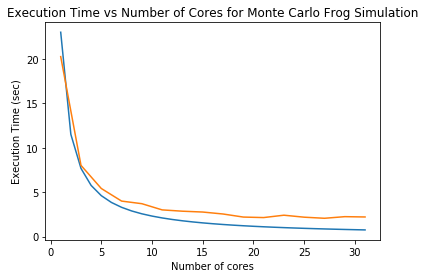

In [13]:
%matplotlib inline
# Plot the times we collected
import matplotlib.pyplot as plt
import numpy as np

#h Helper function to plot an equation
def graph(formula, x_range):  
    x = np.array(x_range)  
    y = formula(x) 
    plt.plot(x, y)  

# Graph theoretical maximum (in blue)
graph(lambda x: 23/x, range(1, 32))

# Graph empirical data (in orange)
plt.plot(range(1,32, 2), times)

plt.ylabel("Execution Time (sec)")
plt.xlabel("Number of cores")
plt.title("Execution Time vs Number of Cores for Monte Carlo Frog Simulation")
plt.show()

## III. Distributed Benchmarking
Distributed benchmarking is, as it sounds, benchmarking a distributed algorithm on a distributed system. Many of the considerations you need to make when you write a distributed algorithm also need to be made when you benchmark a distributed algorithm as well. You need to worry about what parts of your algorithm can run concurrently, as often, things can be offloaded to remote machines if they can be run concurrently. You need to worry about which parts of your process need to access things from other parts, because you can't depend on all of the remote parts of your code having access to the same memory pool as any other part. Because of this, you need to worry about how you can have the processes communicate with each other. Because of all of this complexity, you need to make sure you know how you can ensure that your benchmarking does not affect the output or speed of your algorithm.

### Example 7.3 - Timing Parallel Algorithms on Many Machines
We've now benchmarked our algorithm and our machine with one machine. Now, let's use Parsl to help us benchmark our algorithms on the entire HPC system. We're going to be using our friend the Monte Carlo Pi simulation in order to help us do that.

In [7]:
# Workflow defined here:
from parsl import *
import logging
dfk = DataFlowKernel(executors=[ThreadPoolExecutor(max_workers=32)])

@App('python', dfk)
def pi(total):
    # App functions have to import modules they will use.
    import random
    # Set the size of the box (edge length) in which we drop random points
    edge_length = 10000
    center = edge_length / 2
    c2 = center ** 2
    count = 0

    for i in range(total):
        # Drop a random point in the box.
        x, y = random.randint(1, edge_length), random.randint(1, edge_length)
        # Count points within the circle
        if (x - center)**2 + (y - center)**2 < c2:
            count += 1

    return (count * 4 / total)


@App('python', dfk)
def avg_n(inputs=[]):
    return sum(inputs) / len(inputs)


In [8]:
from parsl import *
import logging
import os
import time
os.environ['SGE_ROOT'] = '/local/cluster/sge'

# Call the workflow:
times = []
for i in range(1, 32, 2):
    ipp_config = {
    "sites": [{
        "site": "LC_Cluster",
        "auth": {
            "channel": "local"
        },
        "execution": {
            "executor": "ipp",
            "provider": "sge",
            "script_dir": ".scripts",
            "scriptDir": ".scripts",
            "block": {
                "nodes": 1,
                "taskBlocks": 1,
                "walltime": "00:05:00",
                "initBlocks": 1,
                "minBlocks": 0,
                "maxBlocks": 10,
                "scriptDir": ".",
                "options": {
                    "partition": "debug"
                }
            }
        }
    }],
    "globals": {"lazyErrors": True},
    "controller": {"profile": "default"},
    }

    N = 10
    # Change the max cores programmatically
    ipp_config["sites"][0]["execution"]["block"]["maxBlocks"] = i
    dfk = DataFlowKernel(config=ipp_config)
    
    before = time.time()
    sims = [pi(10**6) for i in range(N)]
    avg_pi = avg_n([task.result() for task in sims])
    after = time.time()
    tot = after-before
    times.append(tot)
    print("Average: {} ({} cores, {} sec)".format(avg_pi.result(), i, tot))
    dfk.cleanup()

Average: 3.1413012 (1 cores, 31.70084261894226 sec)
Average: 3.142164 (2 cores, 30.619962692260742 sec)
Average: 3.1419068 (3 cores, 30.057994604110718 sec)
Average: 3.1418671999999996 (4 cores, 32.9293897151947 sec)
Average: 3.1413976 (5 cores, 31.5192928314209 sec)
Average: 3.141296 (6 cores, 33.27272057533264 sec)
Average: 3.1419968000000003 (7 cores, 33.408687353134155 sec)
Average: 3.1415204 (8 cores, 32.122639179229736 sec)
Average: 3.1409136 (9 cores, 31.64089798927307 sec)


KeyboardInterrupt: 

In [ ]:
# Graph the results
%matplotlib inline
# Plot the times we collected
import matplotlib.pyplot as plt
import numpy as np

#h Helper function to plot an equation
def graph(formula, x_range):  
    x = np.array(x_range)  
    y = formula(x) 
    plt.plot(x, y)  

# Graph theoretical maximum (in blue)
graph(lambda x: 32/x, range(1, 32))

# Graph empirical data (in orange)
plt.plot(range(1,32, 2), times)

plt.ylabel("Execution Time (sec)")
plt.xlabel("Number of cores")
plt.title("Execution Time vs Number of Cores for Monte Carlo Pi")
plt.show()

## System Benchmarking
So we've done a bunch of benchmarking of our software. Next, we are going to do some hardware benchmarking. Earlier in the notebook, I said "Benchmarking is usually associated with assessing performance characteristics of computer hardware, for example, the floating point operation performance of a CPU", and we're about to calculate exactly that. 

The way we will do this is by the following process: First, come up with a task that will take a constant amount of computer power. Then, compute what that amount of power is, by counting the number of floating point instructions that it will take to run the code. Then, repeatedly time the code and divide the number of floating point instructions by the time it took to get a measurement in FLOPS of how performant our computer is.

### Example 7.4 - Using a Workflow to Estimate System Power
We're going to perform a fixed number of floating point instructions, specifically floating point adds, in a Python loop. Note that there is significant overhead involved with starting a python loop, so the quote of roughly 950 GFLOPS (last time I tested it) is quite a low estimate for this single machine.

In [39]:
import time

before = time.time()
for i in range(10 ** 6):
    floating_point = 1.0
    float_increment = 1.0
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
after = time.time()
tot = after-before
print("20M FLOP in {} sec, {}GFLOPS".format(tot, ((20.5**7)/tot)/10**6))

20M FLOP in 1.5303223133087158 sec, 994.2466050865017GFLOPS


## Exercise 7. System Benchmarking
Implement a workflow which takes a fixed amount of compute power. Calculate what that power is. Then, run it on one core. Run it on many cores. Finally, run it on many nodes. Use the speedup to calculate how powerful one core, one machine, and the entire system is.

Enter a password to testaab
Cracked aab 2
0.001859426498413086 seconds
